In [45]:
%cd /workspace/Two_Stream_PyTorch/project

from main import get_parameters
from IPython.display import clear_output

config, unkonwn = get_parameters()

config.clip_duration = 1
config.num_workers = 3
config.uniform_temporal_subsample_num = 10
config.batch_size = 4
config.gpu_num = 1
config.img_size = 256

clear_output()

In [46]:
from typing import Any, Callable, Dict, Optional, Type

import os 
import torch 
import pytorchvideo
from pytorchvideo.data.clip_sampling import ClipSampler

from pytorchvideo.data.labeled_video_dataset import LabeledVideoDataset
from pytorchvideo.data import labeled_video_dataset, make_clip_sampler

In [47]:
def WalkDataset(
    data_path: str,
    clip_sampler: ClipSampler,
    video_sampler: Type[torch.utils.data.Sampler] = torch.utils.data.RandomSampler,
    transform: Optional[Callable[[Dict[str, Any]], Dict[str, Any]]] = None,
    video_path_prefix: str = "",
    decode_audio: bool = False,
    decoder: str = "pyav",
) -> LabeledVideoDataset:
    '''
    A helper function to create "LabeledVideoDataset" object for the Walk dataset.

    Args:
        data_path (str): Path to the data. The path defines how the data should be read. For a directory, the directory structure defines the classes (i.e. each subdirectory is class).
        clip_sampler (ClipSampler): Defines how clips should be sampled from each video. See the clip sampling documentation for more information.
        video_sampler (Type[torch.utils.data.Sampler], optional): Sampler for the internal video container. Defaults to torch.utils.data.RandomSampler.
        transform (Optional[Callable[[Dict[str, Any]], Dict[str, Any]]], optional): This callable is evaluated on the clip output before the clip is returned. Defaults to None.
        video_path_prefix (str, optional): Path to root directory with the videos that are
                loaded in ``LabeledVideoDataset``. Defaults to "".
        decode_audio (bool, optional): If True, also decode audio from video. Defaults to False. Notice that, if Ture will trigger the stack error.
        decoder (str, optional): Defines what type of decoder used to decode a video. Defaults to "pyav".

    Returns:
        LabeledVideoDataset: _description_
    '''
    return labeled_video_dataset(
        data_path,
        clip_sampler,
        video_sampler,
        transform,
        video_path_prefix,
        decode_audio,
        decoder
    )


In [48]:
from pytorchvideo.transforms import (
    ApplyTransformToKey,
    Normalize,
    RemoveKey,
    ShortSideScale,
    RandomShortSideScale,
    UniformTemporalSubsample,
    Div255,
    RandomResizedCrop,
    create_video_transform
)

from torchvision.transforms import (
    Compose,
    Lambda,
    RandomCrop,
    RandomHorizontalFlip,
    Resize,
    ToTensor,
    
)

In [49]:
num_frame = 8
sample_rate = 8

fps = 30 

clip_duration = num_frame * sample_rate / fps

clip_duration

config.clip_duration = clip_duration


In [50]:

class WalkDataModule():
    def __init__(self, opt):
        super().__init__()
        # self._DATA_PATH = opt.split_pad_data_path
        self._DATA_PATH = opt.split_data_path
        self._CLIP_DURATION = opt.clip_duration
        
        self._BATCH_SIZE = opt.batch_size
        self._NUM_WORKERS = opt.num_workers
    
        self.uniform_temporal_subsample_num = opt.uniform_temporal_subsample_num 

    def train_dataloader(self):
        '''
        create the Walk train partition from the list of video labels 
        in directory and subdirectory. Add transform that subsamples and 
        normalizes the video before applying the scale, crop and flip augmentations.
        '''        
        train_transform = Compose(
            [
                ApplyTransformToKey(
                    key="video",
                    transform=Compose(
                        [
                            Div255(),
                            UniformTemporalSubsample(self.uniform_temporal_subsample_num),
                            # RandomCrop(224),
                        ]
                    ),
                ),
            ]
        )

        # train_transform = Compose(create_video_transform(mode='val', video_key='video', num_samples=8, crop_size=(256, 256), convert_to_float=False),

        train_dataset = WalkDataset(
            data_path= os.path.join(self._DATA_PATH, 'train'),
            clip_sampler=make_clip_sampler("random", self._CLIP_DURATION),
            transform=train_transform
        )

        return torch.utils.data.DataLoader(
            train_dataset,
            batch_size = self._BATCH_SIZE,
            num_workers = self._NUM_WORKERS,
        )

In [51]:
data_module = WalkDataModule(config).train_dataloader()

batch = next(iter(data_module))
batch.keys()

dict_keys(['video', 'video_name', 'video_index', 'clip_index', 'aug_index', 'label'])

In [52]:
batch['video'].shape, batch['video_name'], batch['video_index'], batch['clip_index'], batch['label'], batch['aug_index']

(torch.Size([4, 3, 10, 512, 512]),
 ['20160927_DHS_lat_V1-0010.mp4',
  '20180123_ASD_lat__V1-0009.mp4',
  '20180205_ASD_lat__V1-0039.mp4',
  '20170612_1_ASD_lat_V1-0020.mp4'],
 tensor([932, 201, 249,  76]),
 tensor([0, 0, 0, 0]),
 tensor([1, 0, 0, 0]),
 tensor([0, 0, 0, 0]))

20160927_DHS_lat_V1-0010.mp4


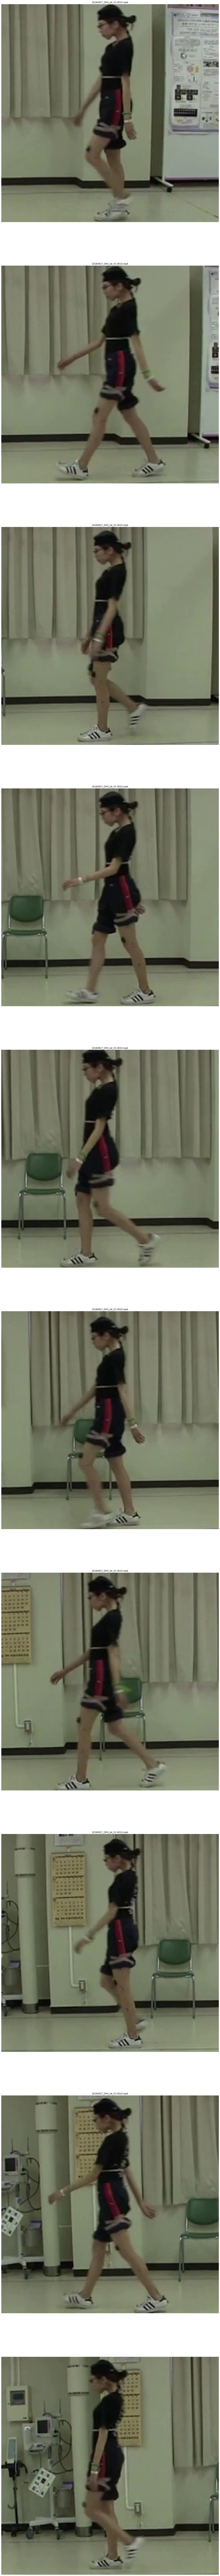

In [53]:
import matplotlib.pylab as plt 

print(batch['video_name'][0])

plt.figure(figsize=(256, 256))

b, c, t, h, w = batch['video'].size()

for i in range(t):
    plt.title(batch['video_name'][0])
    plt.subplot(t, 1, i + 1)
    plt.imshow(batch['video'][0].permute(1, 2, 3, 0)[i])

    plt.axis("off")

plt.show()